In [1]:
# !pip install odfpy
# !pip install seaborn
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy.stats import ttest_ind, mannwhitneyu

In [2]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'SWISS_MaleUrine_Exposure'
subjects = ace.list_subjects(root_directory)
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'

In [3]:
# Take the SW > 19
subjects = [sub for sub in subjects if sub[0:2]=='SW' and int(sub[2:].split('_')[0]) in set(range(19,36))]

In [4]:
# load query file where we added volumes for each area
volumes = pd.read_csv("query_volumes_reordered.csv")
volumes = ace.clean_volumes_database(volumes)

In [5]:
def load_subject(subject):
    df_mouse = pd.read_csv(data_directory + subject + '/cells150_7-7.csv')
    df_mouse = ace.reformat_df_mouse(df=df_mouse)
    return df_mouse

# Analysis on SWISS 19-35 with father : threshold 300

In [6]:
# NB: Run only if file does not exist or needs to be regenerated
dict_results_across_mice = {subject: ace.calculate_cells_energy_per_level(df_mouse=load_subject(subject), 
                                                                          vol=volumes, 
                                                                          level=8) for subject in subjects}
np.save('dict_results/dict_results_across_mice_SW19-35-150_7-7.npy', dict_results_across_mice)

/home/stella/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/stella/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/stella/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/stella/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/stella/anaconda2/lib/pytho

In [7]:
dict_results_across_mice = np.load('dict_results/dict_results_across_mice_SW19-35-150_7-7.npy', allow_pickle=True).item()

In [8]:
# removed key corresponding to SW21_Fam
dict_results_across_mice.pop('SW21_Fam')
subjects.remove('SW21_Fam')

# List areas with null cell count

In [9]:
db_null_count = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject].n_cells == 0] for subject in subjects}

# List areas with no volume

In [10]:
db_null_volume = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject]['energy'].isnull()] for subject in subjects}

# Divide mice into experimental groups: FAM/UNFAM/CONTROL

In [11]:
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)
experimental_groups

{'Control': ['SW25_Control',
  'SW19_Control',
  'SW24_Control',
  'SW31_Control',
  'SW30_Control'],
 'Unfam': ['SW26_Unfam',
  'SW20_Unfam',
  'SW22_Unfam',
  'SW28_Unfam',
  'SW34_Unfam',
  'SW32_Unfam'],
 'Fam': ['SW27_Fam', 'SW23_Fam', 'SW29_Fam', 'SW33_Fam', 'SW35_Fam']}

# Calculate cell count across experimental groups

In [12]:
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

## Calculate t-tests across groups per area

In [13]:
df_ttest_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count)
df_ttest_ncells

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.113993,0.518548,0.202871
1,Primary motor area,0.337185,0.6824,0.367493
2,Secondary motor area,0.298756,0.722306,0.287642
3,Primary somatosensory area,0.21936,0.585518,0.161836
4,Supplemental somatosensory area,0.228194,0.709713,0.137133
...,...,...,...,...
194,Interfascicular nucleus raphe,0.2024,0.0656042,0.80476
195,Interpeduncular nucleus,0.34517,0.2388,0.698535
196,Rostral linear nucleus raphe,0.281977,0.368229,0.535364
197,Central linear nucleus raphe,0.165331,0.2078,0.369795


In [14]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [15]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Ventral premammillary nucleus,1.03416e-05
Medial amygdalar nucleus,0.000513121
Posterior amygdalar nucleus,0.000636082
Submedial nucleus of the thalamus,0.00253557
Anterior tegmental nucleus,0.00889538
Parastrial nucleus,0.0188781
Vascular organ of the lamina terminalis,0.0337354
Pretectal region,0.0375438
Central amygdalar nucleus,0.0524381


In [16]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Medial amygdalar nucleus,0.000698521
Ventral premammillary nucleus,0.00096141
Posterior amygdalar nucleus,0.00193396
Submedial nucleus of the thalamus,0.00295832
Accessory olfactory bulb,0.0131979
Preparasubthalamic nucleus,0.023395
Infralimbic area,0.0376675
Septohippocampal nucleus,0.0535005
Interfascicular nucleus raphe,0.0656042


In [17]:
# sort dataframe pvalues of fam vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Paraventricular hypothalamic nucleus descending division,0.018147
Preparasubthalamic nucleus,0.0294521
Dorsal auditory area,0.0296309
Septohippocampal nucleus,0.0335795
Anterior tegmental nucleus,0.0681208
Superior colliculus sensory related,0.0695595
Caudoputamen,0.0739876
Reticular nucleus of the thalamus,0.0751095
Central amygdalar nucleus,0.0930472


## Mann Whitney Test for comparison across groups

In [18]:
df_mannwhitneyu_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count,
                                           test='mannwhitneyu')
df_mannwhitneyu_ncells

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.0473465,0.261408,0.117667
1,Primary motor area,0.201698,0.463632,0.0854518
2,Secondary motor area,0.265435,0.463632,0.117667
3,Primary somatosensory area,0.148135,0.392096,0.117667
4,Supplemental somatosensory area,0.148135,0.392096,0.0854518
...,...,...,...,...
194,Interfascicular nucleus raphe,0.132603,0.0463003,0.322528
195,Interpeduncular nucleus,0.417266,0.100108,0.392096
196,Rostral linear nucleus raphe,0.362041,0.250291,0.461671
197,Central linear nucleus raphe,0.376649,0.155431,0.46355


In [19]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_mannwhitneyu_not_null_ncells = df_mannwhitneyu_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [20]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_ncells.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Submedial nucleus of the thalamus,0.00583366
Parastrial nucleus,0.00596262
Medial amygdalar nucleus,0.00609289
Posterior amygdalar nucleus,0.00609289
Ventral premammillary nucleus,0.00609289
Anterior tegmental nucleus,0.00924539
Infralimbic area,0.0107859
Posterior limiting nucleus of the thalamus,0.0296635
Pretectal region,0.0300514


In [21]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_mannwhitneyu_not_null_ncells.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Medial amygdalar nucleus,0.00405656
Posterior amygdalar nucleus,0.00405656
Ventral premammillary nucleus,0.00405656
Submedial nucleus of the thalamus,0.00486064
Accessory olfactory bulb,0.0112394
Preparasubthalamic nucleus,0.016634
Paraventricular hypothalamic nucleus,0.0273406
Main olfactory bulb,0.0276171
Tuberal nucleus,0.0410693


In [22]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_ncells.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:35].set_index('area')

,pval_Fam_vs_Unfam
area,
Septohippocampal nucleus,0.0173593
Paraventricular hypothalamic nucleus descending division,0.0178819
Preparasubthalamic nucleus,0.0246014
Dorsal auditory area,0.0273406
Piriform area,0.0276171
Triangular nucleus of septum,0.033632
Anterior tegmental nucleus,0.0404643
Central amygdalar nucleus,0.0414187
Visceral area,0.0414187


## Calculate cross corr across groups per area on cell count

In [23]:
corr_matrix_control_ncells = ace.cross_corr(df_control_cell_count)
corr_matrix_fam_ncells = ace.cross_corr(df_fam_cell_count)
corr_matrix_unfam_ncells = ace.cross_corr(df_unfam_cell_count)

## Plot cross corr matrix across groups per area on cell count

Text(0.5, 1.0, 'CONTROL')

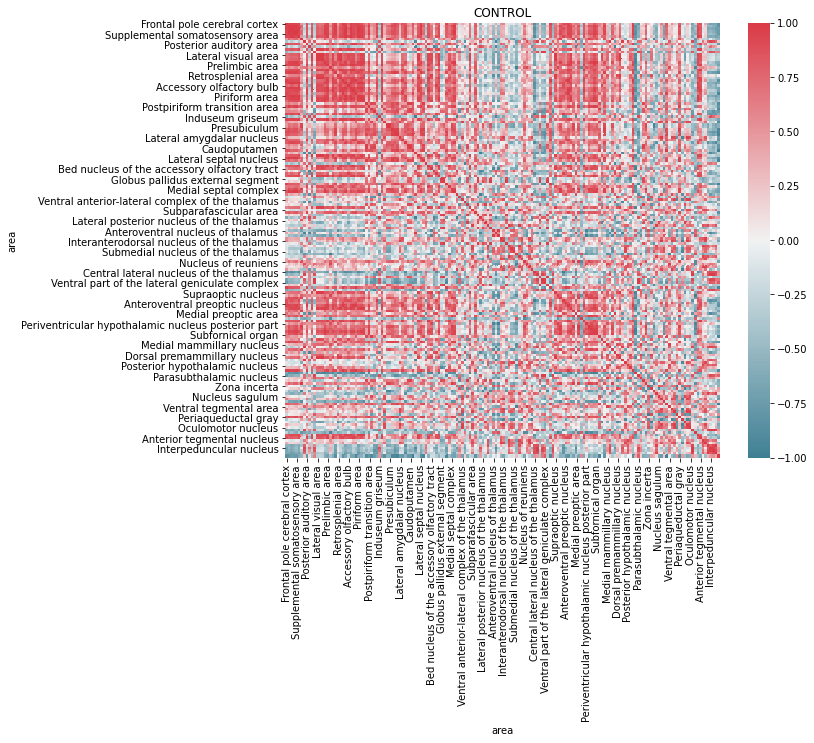

In [24]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

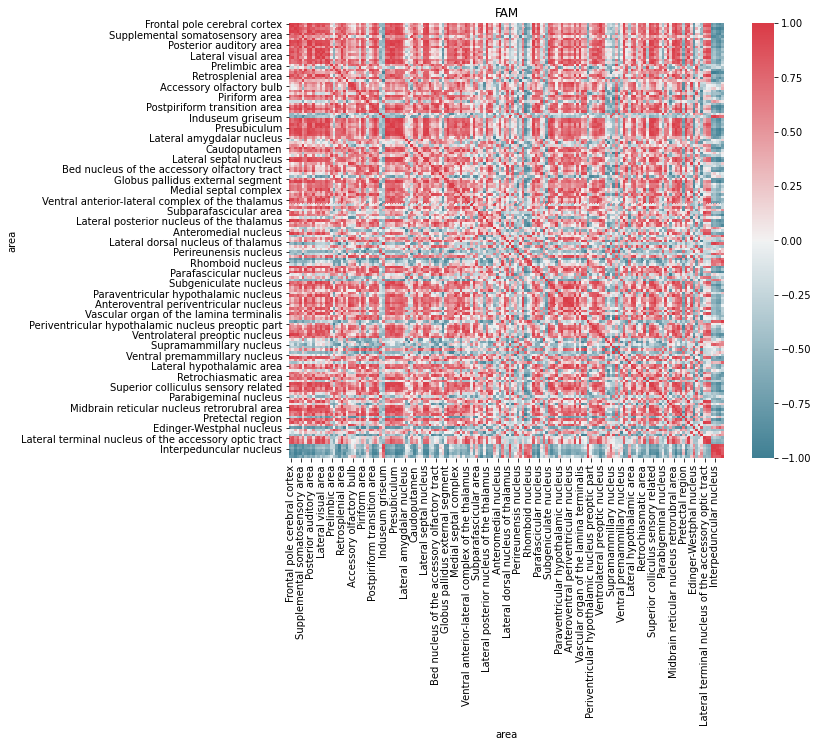

In [25]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

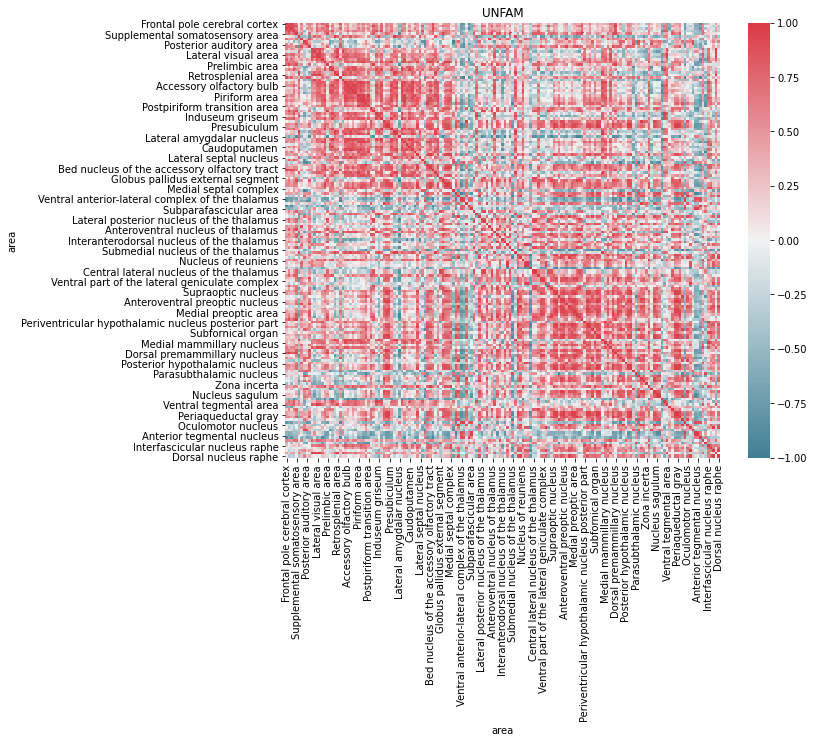

In [26]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')

# Calculate energy across experimental groups

In [27]:
df_control_energy, df_fam_energy, df_unfam_energy = \
ace.calculate_value_across_groups(experimental_groups, dict_results_across_mice, value='energy')

## T-test on energy across groups

In [28]:
df_ttest_energy = ace.test_across_groups(df_control=df_control_energy,
                                      df_fam=df_fam_energy,
                                      df_unfam=df_unfam_energy)

In [29]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_energy = df_ttest_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [30]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Ventral premammillary nucleus,9.15013e-05
Medial amygdalar nucleus,0.00110948
Posterior amygdalar nucleus,0.00246393
Parastrial nucleus,0.0148624
Anterior tegmental nucleus,0.0220855
Cortical amygdalar area,0.0296641
Piriform-amygdalar area,0.0344678
Submedial nucleus of the thalamus,0.0386653
Pretectal region,0.0428025


In [31]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Medial amygdalar nucleus,0.000464608
Ventral premammillary nucleus,0.000724993
Posterior amygdalar nucleus,0.0031339
Cortical amygdalar area,0.0301653
Accessory olfactory bulb,0.0325091
Piriform-amygdalar area,0.0341495
Submedial nucleus of the thalamus,0.0421029
Preparasubthalamic nucleus,0.0463225
Infralimbic area,0.0495721


In [32]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Paraventricular hypothalamic nucleus descending division,0.0241003
Dorsal auditory area,0.0376302
Septohippocampal nucleus,0.0403993
Bed nucleus of the anterior commissure,0.0640401
Preparasubthalamic nucleus,0.0681691
Superior colliculus sensory related,0.0763933
Reticular nucleus of the thalamus,0.0772109
Perirhinal area,0.0971033
Ventral part of the lateral geniculate complex,0.106409


## Mann-Whitney Test across groups

In [33]:
df_mannwhitneyu_energy = ace.test_across_groups(df_control=df_control_energy,
                                      df_fam=df_fam_energy,
                                      df_unfam=df_unfam_energy,
                                    test='mannwhitneyu')

In [34]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_mannwhitneyu_not_null_energy = df_mannwhitneyu_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [35]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_energy.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:40].set_index('area')

,pval_Control_vs_Fam
area,
Submedial nucleus of the thalamus,0.00609289
Medial amygdalar nucleus,0.00609289
Retroethmoid nucleus,0.00609289
Anterior hypothalamic area,0.00609289
Lateral strip of striatum,0.00609289
Posterior amygdalar nucleus,0.00609289
Pineal body,0.00609289
Substantia nigra lateral part,0.00609289
Parastrial nucleus,0.00609289


In [36]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_energy.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:50].set_index('area')

,pval_Control_vs_Unfam
area,
Lateral strip of striatum,0.00405656
Ventral premammillary nucleus,0.00405656
Retroethmoid nucleus,0.00405656
Anterior hypothalamic area,0.00405656
Intercollicular nucleus,0.00405656
Suprachiasmatic preoptic nucleus,0.00405656
Medial amygdalar nucleus,0.00405656
Substantia nigra lateral part,0.00405656
Submedial nucleus of the thalamus,0.00405656


In [37]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_energy.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Control_vs_Fam']][0:50].set_index('area')

,pval_Control_vs_Fam
area,
Substantia nigra lateral part,0.00609289
Nucleus circularis,0.00609289
Pineal body,0.00609289
Anterior hypothalamic area,0.00609289
Lateral strip of striatum,0.00609289
Suprachiasmatic preoptic nucleus,0.00609289
Intercollicular nucleus,0.00609289
Retroethmoid nucleus,0.00609289
Paraventricular hypothalamic nucleus descending division,0.0300514


## Calculate cross corr matrix across experimental groups on energy

In [38]:
corr_matrix_control_energy = ace.cross_corr(df_control_energy)
corr_matrix_fam_energy = ace.cross_corr(df_fam_energy)
corr_matrix_unfam_energy = ace.cross_corr(df_unfam_energy)

## Plot cross corr matrix across groups per area on energy

Text(0.5, 1.0, 'CONTROL')

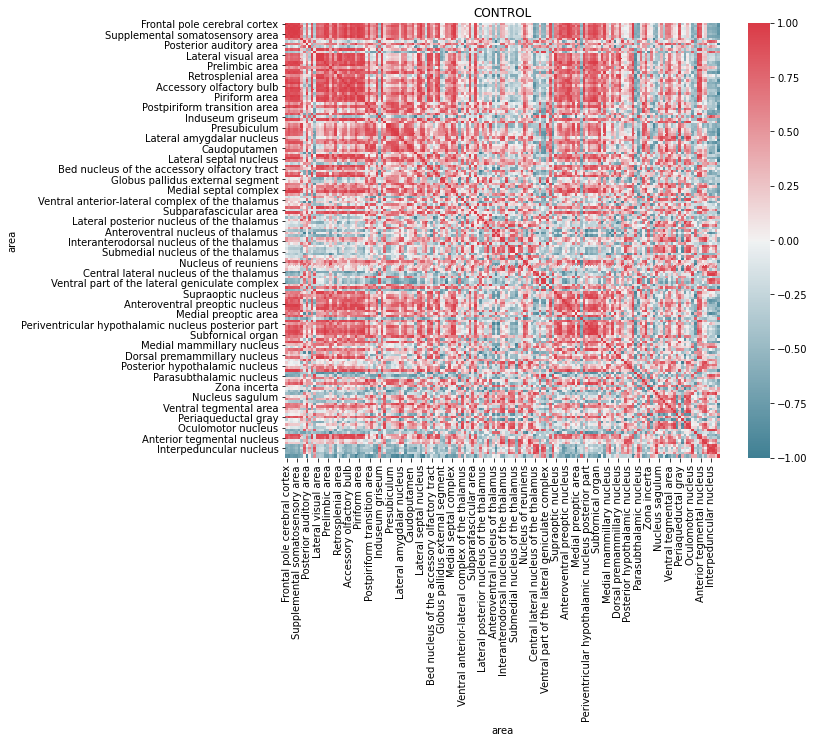

In [39]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

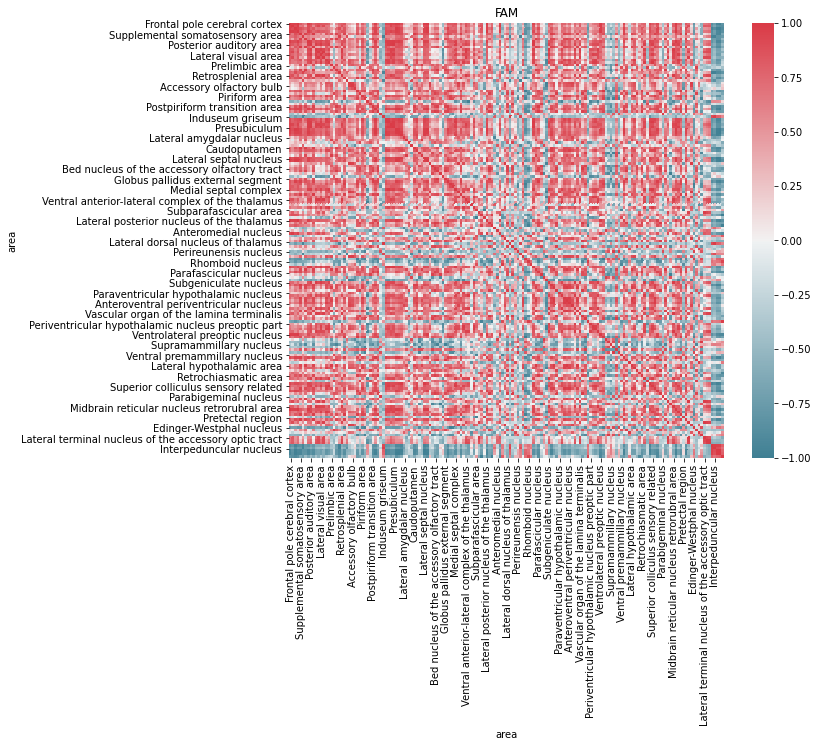

In [40]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

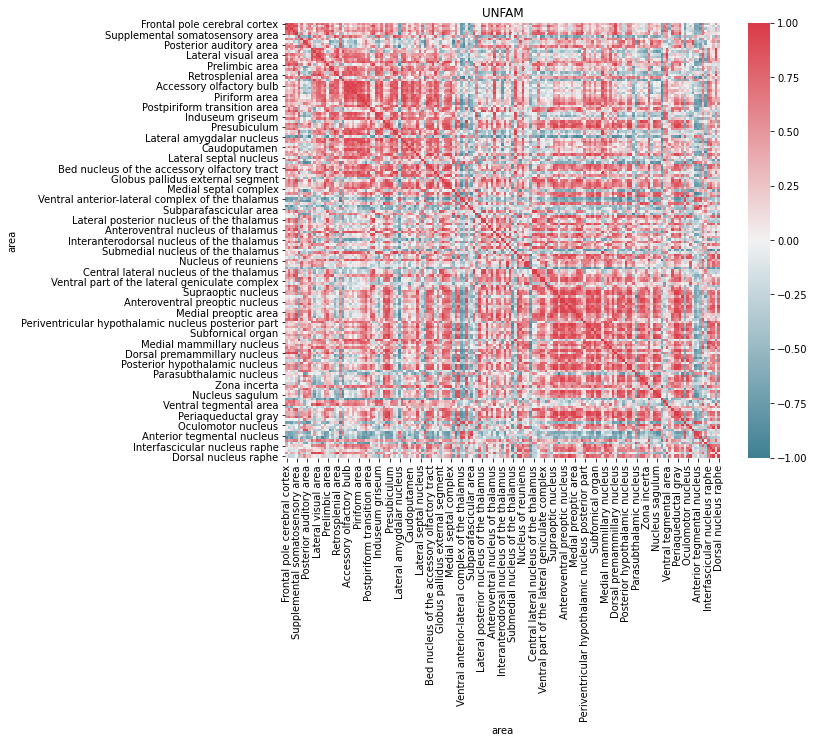

In [41]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')